In [ ]:
!pip install transformers

     |████████████████████████████████| 1.1MB 9.7MB/s 
     |████████████████████████████████| 890kB 33.8MB/s 
     |████████████████████████████████| 1.1MB 48.9MB/s 
     |████████████████████████████████| 3.0MB 30.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=bfc1fcbe095808533e124bdbee6a25a5058a131223e054bc1b0312714aae591b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# --> for cleaning:
!pip install langdetect

     |████████████████████████████████| 983kB 8.2MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=a3d0c53485af8600f7e8e4bbb08567ac888bd167847eb21a9934328e49d51cf8
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizerFast, AutoModel,AdamW
from google.cloud import bigquery
from langdetect import detect
from google.colab import auth,drive
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# specify GPU
device = torch.device("cuda")

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
auth.authenticate_user()

In [ ]:
project_id = 'tlac-vision'

client = bigquery.Client(project=project_id)
df = client.query('''
  SELECT
    *
  FROM
    `tlac-vision.book_backend.train_categories`
''').to_dataframe()

In [ ]:
# --> sorting dataframe by book category, from A to Z
df = df.sort_values(['category'], ascending=True)

# --> dropping duplicate rows
df = df.drop_duplicates(['title']).reset_index(drop=True)

In [ ]:
# --> deleting results that are in other languages different to spanish
df['language'] = ""
for index, row in df.iterrows():
    row['language'] = detect(row['description'])
df = df[df.language == 'es']

df


,category,title,description,language
0,anthropology,El otro es mi espejo,"""Después de 60 años como misionero en el Perú ...",es
1,anthropology,Diccionario de antropología,A lo largo de los últimos cien años la antropo...,es
2,anthropology,La cultura como praxis,"En este libro, uno de los principales teoricos...",es
3,anthropology,"El fuego. Mitos, ritos y realidades","El fuego, presente ya en los inicios del proce...",es
4,anthropology,Tierra encantada,Este ambicioso tratado sobre el fenómeno relig...,es
...,...,...,...,...
2753,sociology,Las tres culturas,An lisis de la relaci n llena de tensiones ent...,es
2754,sociology,Antología de Orlando Fals Borda,Presenta una selección de escritos del sociólo...,es
2755,sociology,Filosofía y sociología en Jesús Ibáñez,“Pocas veces un intelectual ha metabolizado co...,es
2756,sociology,Después del divorcio,El presente trabajo es un estudio de los efect...,es


In [ ]:
# total of registers per category
print(df.iloc[:,0:2].groupby('category').count().rename(columns={'title': 'count'}))

              count
category           
anthropology    102
art             268
business        125
education       275
history         277
literature      228
philosophy      261
poetry          257
psychology      254
science         235
sociology       195


#Data splitting

In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['description'], df['category'],
                                                                    random_state=1992,
                                                                    test_size=0.3,
                                                                    stratify=df['category'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=1992,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

id_label = dict(zip(train_labels.unique(), range(0,11))) #categorical labels to numerical

def conversion(data_set):
  ds_encoded= data_set.map(id_label)
  return ds_encoded

train_labels=conversion(train_labels)
val_labels=conversion(val_labels)
test_labels=conversion(test_labels)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
bert_es = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased") #pretrained model

In [ ]:
# --> sample data for BETO
text = ["esta es una prueba","estoy haciendo una prueba"]
sent_id = tokenizer.batch_encode_plus(text, padding=True) # encode text
print(sent_id)

{'input_ids': [[4, 1149, 1028, 1091, 3610, 5], [4, 1435, 2194, 1091, 3610, 5]], 'token_type_ids': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d544ff5c0>]],
      dtype=object)

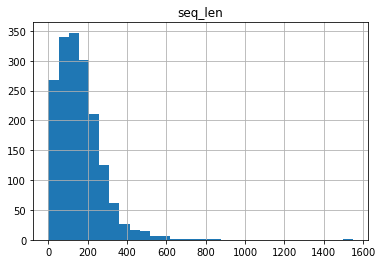

In [ ]:
# --> distribution of the sequence lengths(number of words) in the train set to find the padding length
seq_len = pd.DataFrame([len(i.split()) for i in train_text],columns=['seq_len'])
seq_len.hist(bins = 30)

In [ ]:
def intervals():
  to_return=list()
  j=0
  for i in range(0,32):
    to_return.append(j)
    j+=50

  return to_return

ranges = intervals()

sl_grouped=seq_len.groupby(pd.cut(seq_len.seq_len, ranges)).count().rename(columns={'seq_len':''})
sl_grouped=sl_grouped.add_suffix('count').reset_index()
sl_grouped['%']=round(100*sl_grouped['count'].cumsum()/sl_grouped['count'].sum(),3)

sl_grouped.iloc[0:10,:]

,seq_len,count,%
0,"(0, 50]",250,14.426
1,"(50, 100]",336,33.814
2,"(100, 150]",328,52.741
3,"(150, 200]",302,70.167
4,"(200, 250]",219,82.804
5,"(250, 300]",139,90.825
6,"(300, 350]",67,94.691
7,"(350, 400]",33,96.595
8,"(400, 450]",19,97.692
9,"(450, 500]",17,98.673


In [ ]:
# --> tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

# --> tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

In [ ]:
# --> convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

#data loaders and model architecture

In [ ]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

# dataLoaders
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
#  --> freeze all the layers of the model before fine-tuning it

for param in bert_es.parameters():
    param.requires_grad = False

In [ ]:
# --> model architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert_es):

      super(BERT_Arch, self).__init__()
      self.bert_es = bert_es

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,11)  ####last layer equal to number of classes
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model
      _, cls_hs = self.bert_es(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# --> pass the pre-trained BERT in spanish to architecture
model = BERT_Arch(bert_es)

model = model.to(device) # push the model to GPU

optimizer = AdamW(model.parameters(), lr = 1e-5) # define the optimizer

#compute class weights for the labels in the train set and then pass these weights to the loss function so that it takes care of the class imbalance
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [1.81086729 0.83800774 0.81208997 0.96064302 0.87525253 0.88508682
 0.98465909 0.82054924 0.86090412 2.21895006 1.15842246]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

weights = weights.to(device) # push to GPU

cross_entropy  = nn.NLLLoss(weight=weights) # define the loss function

epochs = 50 # number of training epochs

# Finetuning

In [ ]:
# function to train the model
def train():

  model.train()
  total_loss, total_accuracy = 0, 0
  total_preds=[]   # empty list to save model predictions

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]  # push the batch to gpu

    sent_id, mask, labels = batch

    model.zero_grad() #clear previously calculated gradients

    preds = model(sent_id, mask) # get model predictions for the current batch

    loss = cross_entropy(preds, labels) #compute the loss between actual and predicted values

    total_loss = total_loss + loss.item() # add on to the total loss

    loss.backward() # backward pass to calculate the gradients

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem

    optimizer.step() # update parameters

    preds=preds.detach().cpu().numpy() # model predictions are stored on GPU. it is necessary to push it to CPU

    total_preds.append(preds) # append the model predictions

  avg_loss = total_loss / len(train_dataloader) # compute the training loss of the epoch

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  model.eval() # deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  total_preds = [] # empty list to save the model predictions

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      elapsed = format_time(time.time() - t0) # Calculate elapsed time in minutes.

      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader))) # Report progress.

    batch = [t.to(device) for t in batch] # push the batch to gpu

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      preds = model(sent_id, mask) # model predictions
      loss = cross_entropy(preds,labels) # compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 2.044
Validation Loss: 2.061

 Epoch 2 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 2.029
Validation Loss: 2.049

 Epoch 3 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 2.010
Validation Loss: 2.038

 Epoch 4 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 2.014
Validation Loss: 2.027

 Epoch 5 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.989
Validation Loss: 2.017

 Epoch 6 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.982
Validation Loss: 2.007

 Epoch 7 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.971
Validation Loss: 1.997

 Epoch 8 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.945
Validation Loss: 1.988

 Epoch 9 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.949
Validation Loss: 1.978

 Epoch 10 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.945
Validation L

# Predictions


In [ ]:
#load_weights_of_best_model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
#get_predictions_for_test_data

with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)

In [ ]:
print(classification_report(test_y, preds)) #performance of each category and average

              precision    recall  f1-score   support

           0       0.52      0.89      0.65        19
           1       0.42      0.38      0.39        40
           2       0.46      0.41      0.44        41
           3       0.70      0.46      0.55        35
           4       0.62      0.63      0.62        38
           5       0.70      0.61      0.65        38
           6       0.41      0.26      0.32        34
           7       0.51      0.55      0.53        42
           8       0.51      0.51      0.51        39
           9       0.16      0.19      0.17        16
          10       0.30      0.47      0.37        30

    accuracy                           0.49       372
   macro avg       0.48      0.49      0.47       372
weighted avg       0.50      0.49      0.49       372

